In [1]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                atom = parts[0]
                x, y, z = map(float, parts[1:4])
                atoms.append(atom)
                coords.append([x, y, z])
    return atoms, np.array(coords)

In [3]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Глобальное определение ван-дер-ваальсовых радиусов
vdw_radii = {
    'H': 1.2,
    'C': 1.7,
    'O': 1.52,
    'Br': 1.85,
    'S': 1.80,
    'N': 1.55,
    'Na': 2.27
}

def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as file:
        next(file)  # Пропустить первую строку (количество атомов)
        next(file)  # Пропустить вторую строку (комментарий)
        for line in file:
            parts = line.strip().split()
            atoms.append(parts[0])
            coords.append([float(x) for x in parts[1:4]])
    return atoms, np.array(coords)

def estimate_internal_volume(filename, azim=45, elev=30, grid_resolution=0.5):
    # Шаг 1: Читаем координаты атомов из файла
    atoms, coords = read_coordinates(filename)
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])

    # Визуализация шага 1
    fig1 = visualize_molecule_with_vdw(atoms, coords, azim=azim, elev=elev)

    # Шаг 2: Вычисляем выпуклую оболочку молекулы
    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]

    # Визуализация шага 2
    fig2 = visualize_convex_hull(atoms, coords, hull, azim=azim, elev=elev)

    # Шаг 3: Создаем 3D-сетку внутри границ выпуклой оболочки
    max_radius = max(vdw_radii.values())
    min_coords = np.min(hull_points, axis=0) - max_radius
    max_coords = np.max(hull_points, axis=0) + max_radius
    x = np.arange(min_coords[0], max_coords[0], grid_resolution)
    y = np.arange(min_coords[1], max_coords[1], grid_resolution)
    z = np.arange(min_coords[2], max_coords[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    grid_points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    # Визуализация шага 3
    fig3 = visualize_grid_points(grid_points, atoms, coords, azim=azim, elev=elev)

    # Шаг 4: Определяем точки внутри выпуклой оболочки
    delaunay = Delaunay(hull_points)
    inside_hull = delaunay.find_simplex(grid_points) >= 0
    points_in_hull = grid_points[inside_hull]

    # Шаг 5: Определяем точки внутри атомов
    tree = cKDTree(coords)
    max_atom_radius = max(atom_radii)
    indices = tree.query_ball_point(points_in_hull, r=max_atom_radius)
    inside_atom = np.zeros(len(points_in_hull), dtype=bool)

    for i, inds in enumerate(indices):
        point = points_in_hull[i]
        for j in inds:
            distance = np.linalg.norm(point - coords[j])
            if distance <= atom_radii[j]:
                inside_atom[i] = True
                break

    # Визуализация шага 4 и 5
    fig4 = visualize_inside_atoms(points_in_hull, inside_atom, atoms, coords, azim=azim, elev=elev)

    # Шаг 6: Точки внутри полости
    cavity_points = points_in_hull[~inside_atom]

    # Визуализация шага 6
    fig5 = visualize_cavity(points_in_hull, inside_atom, atoms, coords, azim=azim, elev=elev)

    # Вычисляем объемы
    volume_total = hull.volume
    volume_atom = np.sum(inside_atom) * (grid_resolution ** 3)
    volume_cavity = np.sum(~inside_atom) * (grid_resolution ** 3)

    # Объединенная визуализация
    fig6 = visualize_all_steps(atoms, coords, hull, grid_points, points_in_hull, inside_atom, cavity_points, azim=azim, elev=elev)

    return (fig1, fig2, fig3, fig4, fig5, fig6), (volume_total, volume_atom, volume_cavity)

def visualize_molecule_with_vdw(atoms, coords, azim=45, elev=30):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    unique_atoms = set(atoms)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atoms)))
    atom_color = dict(zip(unique_atoms, colors))
    for atom, coord in zip(atoms, coords):
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=atom_color[atom], alpha=0.3)
        ax.scatter(coord[0], coord[1], coord[2], color=atom_color[atom], s=20)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title('Шаг 1: Молекула с ван-дер-ваальсовыми радиусами')
    plt.show()
    return fig

def visualize_convex_hull(atoms, coords, hull, azim=45, elev=30):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Отображаем ван-дер-ваальсовы сферы
    unique_atoms = set(atoms)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atoms)))
    atom_color = dict(zip(unique_atoms, colors))
    for atom, coord in zip(atoms, coords):
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=atom_color[atom], alpha=0.3)
        ax.scatter(coord[0], coord[1], coord[2], color=atom_color[atom], s=20)

    # Визуализируем выпуклую оболочку
    for simplex in hull.simplices:
        triangle = coords[simplex]
        ax.plot_trisurf(triangle[:, 0], triangle[:,1], triangle[:,2], color='cyan', alpha=0.2)

    ax.view_init(elev=elev, azim=azim)
    ax.set_title('Шаг 2: Выпуклая оболочка с ван-дер-ваальсовыми радиусами')
    plt.show()
    return fig

def visualize_grid_points(grid_points, atoms, coords, azim=45, elev=30):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Отображаем подвыборку точек сетки
    sample_indices = np.random.choice(len(grid_points), size=min(500, len(grid_points)), replace=False)
    sample_points = grid_points[sample_indices]
    ax.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='grey', s=1, alpha=0.5, label='Сетка')

    # Отображаем ван-дер-ваальсовы сферы
    unique_atoms = set(atoms)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atoms)))
    atom_color = dict(zip(unique_atoms, colors))
    for atom, coord in zip(atoms, coords):
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=atom_color[atom], alpha=0.3)
        ax.scatter(coord[0], coord[1], coord[2], color=atom_color[atom], s=20)

    ax.view_init(elev=elev, azim=azim)
    ax.set_title('Шаг 3: 3D-сетка с ван-дер-ваальсовыми радиусами')
    plt.legend()
    plt.show()
    return fig

def visualize_inside_atoms(points_in_hull, inside_atom, atoms, coords, azim=45, elev=30):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Точки внутри атомов
    atom_points = points_in_hull[inside_atom]
    sample_indices = np.random.choice(len(atom_points), size=min(500, len(atom_points)), replace=False)
    sample_points = atom_points[sample_indices]
    ax.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='red', s=1, label='Внутри атомов')

    # Отображаем ван-дер-ваальсовы сферы
    unique_atoms = set(atoms)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atoms)))
    atom_color = dict(zip(unique_atoms, colors))
    for atom, coord in zip(atoms, coords):
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=atom_color[atom], alpha=0.3)
        ax.scatter(coord[0], coord[1], coord[2], color=atom_color[atom], s=20)

    ax.view_init(elev=elev, azim=azim)
    ax.set_title('Шаг 4: Точки внутри атомов с ван-дер-ваальсовыми радиусами')
    plt.legend()
    plt.show()
    return fig

def visualize_cavity(points_in_hull, inside_atom, atoms, coords, azim=45, elev=30):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Точки внутри полости
    cavity_points = points_in_hull[~inside_atom]
    sample_indices = np.random.choice(len(cavity_points), size=min(500, len(cavity_points)), replace=False)
    sample_points = cavity_points[sample_indices]
    ax.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='green', s=1, label='Полость')

    # Отображаем ван-дер-ваальсовы сферы
    unique_atoms = set(atoms)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atoms)))
    atom_color = dict(zip(unique_atoms, colors))
    for atom, coord in zip(atoms, coords):
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=atom_color[atom], alpha=0.3)
        ax.scatter(coord[0], coord[1], coord[2], color=atom_color[atom], s=20)

    ax.view_init(elev=elev, azim=azim)
    ax.set_title('Шаг 5: Точки внутри полости с ван-дер-ваальсовыми радиусами')
    plt.legend()
    plt.show()
    return fig

def visualize_all_steps(atoms, coords, hull, grid_points, points_in_hull, inside_atom, cavity_points, azim=45, elev=30):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Отображаем ван-дер-ваальсовы сферы
    unique_atoms = set(atoms)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_atoms)))
    atom_color = dict(zip(unique_atoms, colors))
    for atom, coord in zip(atoms, coords):
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:12j, 0:np.pi:6j]
        x = radius * np.cos(u) * np.sin(v) + coord[0]
        y = radius * np.sin(u) * np.sin(v) + coord[1]
        z = radius * np.cos(v) + coord[2]
        ax.plot_surface(x, y, z, color=atom_color[atom], alpha=0.3)
        ax.scatter(coord[0], coord[1], coord[2], color=atom_color[atom], s=20)

    # Визуализируем выпуклую оболочку
    for simplex in hull.simplices:
        triangle = coords[simplex]
        ax.plot_trisurf(triangle[:, 0], triangle[:,1], triangle[:,2], color='cyan', alpha=0.1)

    # Точки внутри атомов
    atom_points = points_in_hull[inside_atom]
    sample_indices_atom = np.random.choice(len(atom_points), size=min(500, len(atom_points)), replace=False)
    sample_atom_points = atom_points[sample_indices_atom]
    ax.scatter(sample_atom_points[:, 0], sample_atom_points[:, 1], sample_atom_points[:, 2], color='red', s=1, label='Внутри атомов')

    # Точки внутри полости
    sample_indices_cavity = np.random.choice(len(cavity_points), size=min(500, len(cavity_points)), replace=False)
    sample_cavity_points = cavity_points[sample_indices_cavity]
    ax.scatter(sample_cavity_points[:, 0], sample_cavity_points[:, 1], sample_cavity_points[:, 2], color='green', s=1, label='Полость')

    ax.view_init(elev=elev, azim=azim)
    ax.set_title('Шаг 6: Объединенная визуализация с ван-дер-ваальсовыми радиусами')
    plt.legend()
    plt.show()
    return fig


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Глобальное определение ван-дер-ваальсовых радиусов
vdw_radii = {
    'H': 1.2,
    'C': 1.7,
    'O': 1.52,
    'Br': 1.85,
    'S': 1.80,
    'N': 1.55,
    'Na': 2.27
}

def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as file:
        next(file)  # Пропустить первую строку (количество атомов)
        next(file)  # Пропустить вторую строку (комментарий)
        for line in file:
            parts = line.strip().split()
            atoms.append(parts[0])
            coords.append([float(x) for x in parts[1:4]])
    return atoms, np.array(coords)

def estimate_internal_volume(filename, azim=45, elev=30, grid_resolution=0.5):
    atoms, coords = read_coordinates(filename)
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])

    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]

    max_radius = max(vdw_radii.values())
    min_coords = np.min(hull_points, axis=0) - max_radius
    max_coords = np.max(hull_points, axis=0) + max_radius
    x = np.arange(min_coords[0], max_coords[0], grid_resolution)
    y = np.arange(min_coords[1], max_coords[1], grid_resolution)
    z = np.arange(min_coords[2], max_coords[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z)
    grid_points = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

    delaunay = Delaunay(hull_points)
    inside_hull = delaunay.find_simplex(grid_points) >= 0
    points_in_hull = grid_points[inside_hull]

    tree = cKDTree(coords)
    max_atom_radius = max(atom_radii)
    indices = tree.query_ball_point(points_in_hull, r=max_atom_radius)
    inside_atom = np.zeros(len(points_in_hull), dtype=bool)

    for i, inds in enumerate(indices):
        point = points_in_hull[i]
        for j in inds:
            distance = np.linalg.norm(point - coords[j])
            if distance <= atom_radii[j]:
                inside_atom[i] = True
                break

    volume_total = hull.volume
    volume_atom = np.sum(inside_atom) * (grid_resolution ** 3)
    volume_cavity = np.sum(~inside_atom) * (grid_resolution ** 3)

    return (volume_total, volume_atom, volume_cavity)

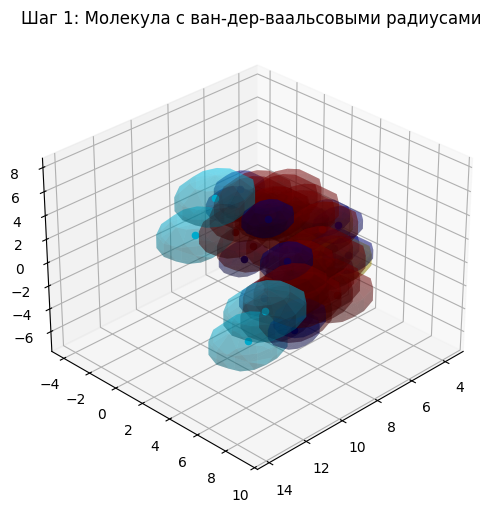

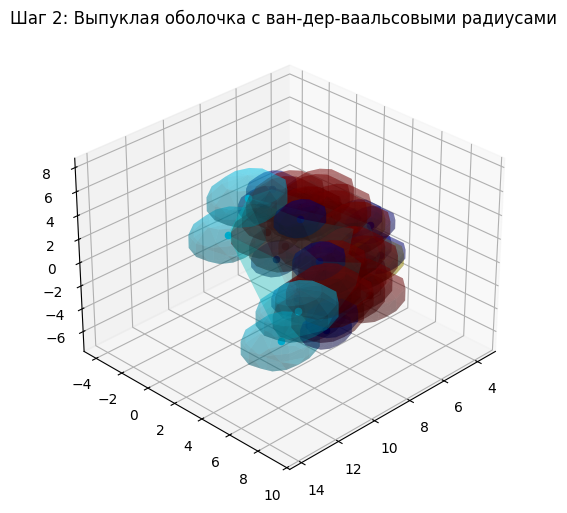

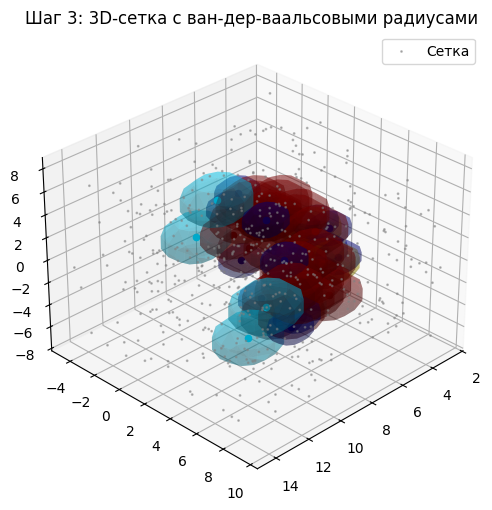

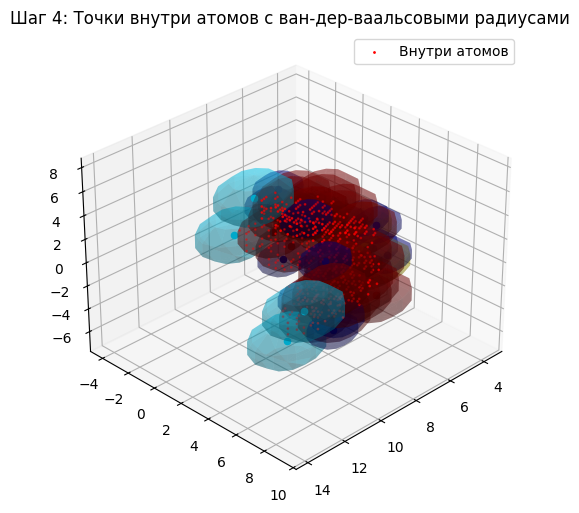

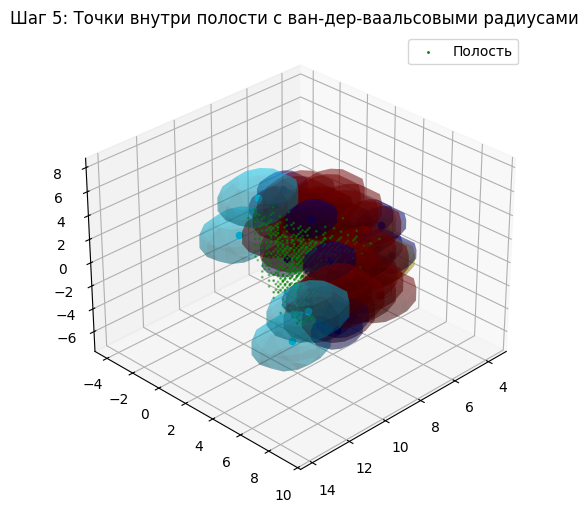

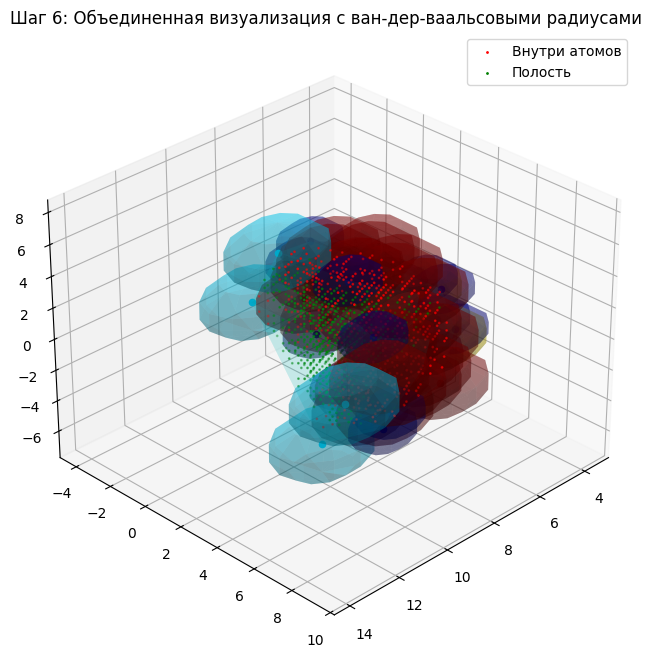

Общий объем выпуклой оболочки: 216.34 Å³
Объем, занятый атомами: 134.00 Å³
Объем полости: 82.38 Å³


In [4]:
filename = '2.txt'  # Укажите путь к вашему файлу с координатами
figures, volumes = estimate_internal_volume(filename)

volume_total, volume_atom, volume_cavity = volumes
print(f"Общий объем выпуклой оболочки: {volume_total:.2f} Å³")
print(f"Объем, занятый атомами: {volume_atom:.2f} Å³")
print(f"Объем полости: {volume_cavity:.2f} Å³")


In [75]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay, KDTree

def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                atom = parts[0]
                x, y, z = map(float, parts[1:4])
                atoms.append(atom)
                coords.append([x, y, z])
    return atoms, np.array(coords)

def estimate_internal_volume(filename, voxel_size=0.1): 
    vdw_radii = {
        'H': 1.2,
        'C': 1.7,
        'O': 1.52,
        'Br': 1.85,
        'S': 1.80,
        'N': 1.55,
        'Na': 2.27
    }

    atoms, coords = read_coordinates(filename)

    # Generate convex hull for bounding the molecule
    hull = ConvexHull(coords)
    delaunay = Delaunay(coords[hull.vertices])
    
    min_coords = np.min(coords, axis=0)
    max_coords = np.max(coords, axis=0)

    # Create a grid of points within the bounding box of the molecule
    x_range = np.arange(min_coords[0], max_coords[0], voxel_size)
    y_range = np.arange(min_coords[1], max_coords[1], voxel_size)
    z_range = np.arange(min_coords[2], max_coords[2], voxel_size)
    
    grid_points = np.array(np.meshgrid(x_range, y_range, z_range)).T.reshape(-1, 3)

    # Use KDTree for efficient distance calculation
    tree = KDTree(coords)
    
    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])
    
    # Check if the grid points fall inside the convex hull using Delaunay triangulation
    inside_hull = delaunay.find_simplex(grid_points) >= 0
    points_in_hull = grid_points[inside_hull]
    
    num_points_in_atoms = 0
    points_in_cavity = []

    # Check each point in the hull if it's inside any atom
    for point in points_in_hull:
        distances, indices = tree.query(point, k=len(coords))
        if np.any(distances <= atom_radii[indices]):
            num_points_in_atoms += 1
        else:
            points_in_cavity.append(point)

    atom_volume = num_points_in_atoms * voxel_size**3
    cavity_volume = len(points_in_cavity) * voxel_size**3
    total_volume = len(points_in_hull) * voxel_size**3
    
    return total_volume, atom_volume, cavity_volume


In [78]:
filename = '2.txt'  # Укажите путь к вашему файлу с координатами
volumes = estimate_internal_volume(filename)

volume_total, volume_atom, volume_cavity = volumes
print(f"Общий объем выпуклой оболочки: {volume_total:.2f} Å³")
print(f"Объем, занятый атомами: {volume_atom:.2f} Å³")
print(f"Объем полости: {volume_cavity:.2f} Å³")

Общий объем выпуклой оболочки: 218.37 Å³
Объем, занятый атомами: 136.90 Å³
Объем полости: 81.47 Å³
